In [98]:
# IMPORTS
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sc
from scipy import linalg, optimize, constants, interpolate, special, stats
import math as ma
from math import exp, pow, sqrt, log
import seaborn as sns 
import statsmodels.api as sm
import statsmodels.stats.api as sms
import keras
import random
from keras.utils import plot_model, to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Reshape
from keras.layers import Conv1D, Conv2D, MaxPooling1D, Flatten, Input, UpSampling1D
from keras.optimizers import SGD
import sklearn as sl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from prettytable import PrettyTable
from keras import backend as K
from sklearn.utils import shuffle


%matplotlib inline

# Autoencoder mit komprimiertem Input (Ausgabe Klasse)

In [111]:
# csv einlesen
Vein = pd.read_csv('datensatz/vein.csv')
# dataframe draus machen
df = pd.DataFrame(Vein)


df = df.iloc[2:, 1:]
df = shuffle(df)

training = df.iloc[0:10, :]

val_inputs = df.iloc[10:, 1:].values
val_inputs = val_inputs.reshape(val_inputs.shape[0],3160,1).astype( 'float32' )

val_class = df.iloc[10:, 0].values


print(training.shape)
#inputs und targets generieren (Spalte 1 für die Targets, Spalte 2 bis Ende für die Inputs)
inputs = training.iloc[:,1:].values
targets = training.iloc[:,0].values

inputs = inputs.reshape(inputs.shape[0],3160,1).astype( 'float32' )
inputs = inputs / np.max(inputs)

print('Input Shape : ' , inputs.shape)
print('Target Shape : ' , targets.shape)

#Trainingsdaten in test und training splitten (7:3)
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size = 0.3)

print('\n-----------------')
#TARGETS
targets_train_categorial = to_categorical(targets_train)
targets_test_categorial = to_categorical(targets_test)


#(Anzahl Datenpunkte, Höhe, Breite, Kanäle)  
print('Training data shape : ', inputs_train.shape, targets_train_categorial.shape)
print('Testing data shape : ', inputs_test.shape, targets_test_categorial.shape)


x = PrettyTable()
x.field_names = ["target", "!has_DM2", "has_DM2"]

i = 0
for target in targets_train_categorial:
    hasNotDM2, hasDM2 = target
    x.add_row([targets_train[i],hasNotDM2, hasDM2])
    i+=1
print(x)

[0. 0. 0. 1. 0. 1. 1. 1. 0.]
(10, 3161)
Input Shape :  (10, 3160, 1)
Target Shape :  (10,)

-----------------
Training data shape :  (7, 3160, 1) (7, 2)
Testing data shape :  (3, 3160, 1) (3, 2)
+--------+----------+---------+
| target | !has_DM2 | has_DM2 |
+--------+----------+---------+
|  0.0   |   1.0    |   0.0   |
|  1.0   |   0.0    |   1.0   |
|  1.0   |   0.0    |   1.0   |
|  0.0   |   1.0    |   0.0   |
|  0.0   |   1.0    |   0.0   |
|  1.0   |   0.0    |   1.0   |
|  1.0   |   0.0    |   1.0   |
+--------+----------+---------+


In [100]:
#Funktion für Plot Loss
from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [117]:
# ENCODER
input_sig = Input(batch_shape=(None,3160,1))
x = Conv1D(16,3, activation='relu', padding='valid')(input_sig)
x1 = MaxPooling1D(2)(x)
x2 = Conv1D(32,3, activation='relu', padding='valid')(x1)
x3 = MaxPooling1D(2)(x2)
flat = Flatten()(x3)
encoded = Dense(64,activation = 'relu')(flat)
 
print("Encoder Shape {}".format(K.int_shape(encoded)))
 
# DECODER 
x2_ = Conv1D(64, 3, activation='relu', padding='valid')(x3)
x1_ = UpSampling1D(2)(x2_)
x_ = Conv1D(32, 3, activation='relu', padding='valid')(x1_)
upsamp = UpSampling1D(2)(x_)
flat = Flatten()(upsamp)
decoded = Dense(2,activation = 'softmax')(flat)
decoded = Reshape((2,1))(decoded)
 
print("Decoder Shape {}".format(K.int_shape(decoded)))
 
autoencoder = Model(input_sig, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
autoencoder.summary()

Encoder Shape (None, 64)
Decoder Shape (None, 2, 1)
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3160, 1)           0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 3158, 16)          64        
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 1579, 16)          0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 1577, 32)          1568      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 788, 32)           0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 786, 64)           6208      
_________________________________________________________________
up_samp

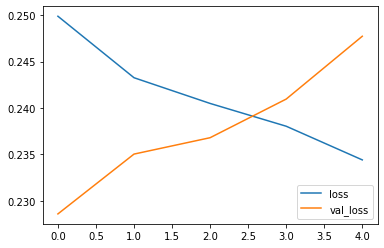

In [118]:
autoencoder_train = autoencoder.fit(inputs_train, targets_train_categorial.reshape(targets_train_categorial.shape[0],2,1).astype( 'float32' ), 
                                    batch_size=14,
                                    epochs=5,
                                    verbose=1,
                                    validation_data=(inputs_test, targets_test_categorial.reshape(targets_test_categorial.shape[0],2,1).astype( 'float32' )),
                                    callbacks=[plot_losses])


In [119]:
#Prediction
pred = autoencoder.predict(val_inputs)
pred.shape


(9, 2, 1)

In [133]:
y = PrettyTable()
y.field_names = ["Testmenge", "Rekonstruktion (!has_DM2)", "Rekonstruktion (has_DM2)", "check"]

i = 0
for i in range(8):
    soll = val_class[i]
    ist = pred[i][0]
    ist2 = pred[i][1]
    check = '\u2716'
    if soll == 0.0 and soll != ist:
        check = u'\u2714'
    elif soll == 1.0 and soll == ist2:
        check = u'\u2714'
    
    y.add_row([soll, ist, ist2, check])
    i+=1
print(y)

+-----------+---------------------------+--------------------------+-------+
| Testmenge | Rekonstruktion (!has_DM2) | Rekonstruktion (has_DM2) | check |
+-----------+---------------------------+--------------------------+-------+
|    0.0    |            [0.]           |           [1.]           |   ✖   |
|    0.0    |            [0.]           |           [1.]           |   ✖   |
|    0.0    |            [0.]           |           [1.]           |   ✖   |
|    1.0    |            [0.]           |           [1.]           |   ✔   |
|    0.0    |            [0.]           |           [1.]           |   ✖   |
|    1.0    |            [0.]           |           [1.]           |   ✔   |
|    1.0    |            [0.]           |           [1.]           |   ✔   |
|    1.0    |            [0.]           |           [1.]           |   ✔   |
+-----------+---------------------------+--------------------------+-------+
